In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

df = pd.read_csv('../dados_tratados/combinado/Piratininga/Piratininga_tratado_combinado.csv',
                 usecols=['PM2.5', 'Data e Hora'])
df.dropna(inplace=True)
df.index = pd.to_datetime(df['Data e Hora'], format='%Y-%m-%d %H:%M:%S')
train_dates = pd.to_datetime(df['Data e Hora'], format='%Y-%m-%d %H:%M:%S')

df['Data e Hora'] = pd.to_datetime(df['Data e Hora'])

# df['hour'] = df['Data e Hora'].dt.hour
# df['minute'] = df['Data e Hora'].dt.minute
# df['year'] = df['Data e Hora'].dt.year
# df['month'] = df['Data e Hora'].dt.month
# df['day'] = df['Data e Hora'].dt.day
# df['day_of_week'] = df['Data e Hora'].dt.dayofweek
# df['day_of_year'] = df['Data e Hora'].dt.dayofyear
# df['week'] = df['Data e Hora'].dt.isocalendar().week

df.drop('Data e Hora', axis=1, inplace=True)



Using cuda


In [40]:
# Normalizando os dados de PM2.5
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(df['PM2.5'].values.reshape(-1, 1))

df['PM2.5'] = scaled_values


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)].astype(np.float32)
        y = data[i + seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 8
X, y = create_sequences(df.values, seq_length)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().reshape(-1, 1)
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().reshape(-1, 1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().reshape(-1, 1)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [41]:
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_layer_size, num_layers, output_size, drop_prob=0.2):
#         super(LSTM, self).__init__()
#         self.hidden_layer_size = hidden_layer_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
#         self.dropout = nn.Dropout(drop_prob)
#         self.linear = nn.Linear(hidden_layer_size, output_size)
# 
#     def forward(self, input_seq):
#         lstm_out, _ = self.lstm(input_seq)
#         predictions = self.linear(lstm_out[:, -1, :])
#         return predictions
# 
# 
# input_size = X_train.shape[2]
# model = LSTM(input_size=input_size, hidden_layer_size=512, num_layers=2, output_size=1).to(device)
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# 
# 
# def train_model(model, train_loader, val_loader, loss_function, optimizer, epochs=150, patience=10):
#     train_losses = []
#     val_losses = []
#     best_val_loss = np.inf
#     counter = 0
#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0.0
#         # Loop de treinamento
#         for seq, labels in train_loader:
#             seq, labels = seq.to(device), labels.to(device)
#             optimizer.zero_grad()
#             y_pred = model(seq)
#             single_loss = loss_function(y_pred, labels)
#             single_loss.backward()
#             optimizer.step()
#             train_loss += single_loss.item() * seq.size(0)
# 
#         train_loss /= len(train_loader.dataset)
#         train_losses.append(train_loss)
# 
#         model.eval()
#         val_loss = 0.0
#         # Loop de validação
#         with torch.no_grad():
#             for seq, labels in val_loader:
#                 seq, labels = seq.to(device), labels.to(device)
#                 y_pred = model(seq)
#                 single_loss = loss_function(y_pred, labels)
#                 val_loss += single_loss.item() * seq.size(0)
# 
#         val_loss /= len(val_loader.dataset)
#         val_losses.append(val_loss)
# 
#         print(f'Epoch {epoch} train loss: {train_loss}, val loss: {val_loss}')
# 
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             counter = 0
#             torch.save(model.state_dict(), 'best_model.pth')
#         else:
#             counter += 1
# 
#         if counter >= patience:
#             print('Early stopping')
#             break
#     return train_losses, val_losses
# 
# 
# train_losses, val_losses = train_model(model, train_loader, val_loader, loss_function, optimizer, epochs=200,
#                                        patience=10)
# 
# model.load_state_dict(torch.load('best_model.pth'))
# 
# model.eval()
# test_predictions = []
# 
# with torch.no_grad():
#     for seq, labels in test_loader:
#         seq, labels = seq.to(device), labels.to(device)
#         y_pred = model(seq)
#         test_predictions.append(y_pred.cpu().numpy())
# 
# test_predictions = np.concatenate(test_predictions, axis=0)
# test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
# y_test = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))
# 
# mae = np.mean(np.abs(test_predictions - y_test))
# mse = np.mean((test_predictions - y_test) ** 2)
# mape = np.mean(np.abs(test_predictions - y_test) / np.abs(y_test)) * 100
# rmse = np.sqrt(mse)
# print("\n\n")
# print("Metrics:")
# print(f'Mean Squared Error: {mse}')
# print(f'Root Mean Squared Error: {rmse}')
# print(f'Mean Absolute Error: {mae}')
# print(f'Mean Absolute Percentage Error: {mape}')
# 
# # Plotagem das perdas de treinamento e validação
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.legend()
# plt.show()


In [42]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

input_size = X_train.shape[2]  # Supondo que X_train seja um tensor com a forma (n_samples, seq_len, n_features)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definição do modelo LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, drop_prob, activation_function):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(drop_prob)
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.activation_function = activation_function

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        if self.activation_function == 'relu':
            predictions = nn.ReLU()(predictions)
        elif self.activation_function == 'sigmoid':
            predictions = nn.Sigmoid()(predictions)
        return predictions

def train_and_evaluate_lstm(input_size, hidden_layer_size, num_layers, lr, batch_size, drop_prob, activation_function, 
                            weight_decay, num_epochs, patience):
    model = LSTM(
        input_size=input_size,
        hidden_layer_size=hidden_layer_size,
        num_layers=num_layers,
        drop_prob=drop_prob,
        output_size=1,
        activation_function=activation_function
    ).to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    # Early stopping 
    best_val_loss = np.inf
    epochs_no_improve = 0
    val_losses = []

    def train_model():
        model.train()
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)
            optimizer.zero_grad()
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

    def evaluate_model():
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for seq, labels in val_loader:
                seq, labels = seq.to(device), labels.to(device)
                y_pred = model(seq)
                single_loss = loss_function(y_pred, labels)
                val_loss += single_loss.item() * seq.size(0)
        val_loss /= len(val_loader.dataset)
        return val_loss

    for epoch in range(num_epochs):
        train_model()
        val_loss = evaluate_model()
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping")
                break

    torch.save(model.state_dict(), 'best_model.pth')
    return model, val_losses

from sklearn.base import BaseEstimator, RegressorMixin

class PyTorchLSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layer_size=100, num_layers=2, lr=0.001, batch_size=64, drop_prob=0.2,
                 activation_function='relu', weight_decay=1e-8, num_epochs=50, patience=5):
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lr = lr
        self.drop_prob = drop_prob
        self.batch_size = batch_size
        self.activation_function = activation_function
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.patience = patience

    def fit(self, X, y):
        self.model = LSTM(input_size=input_size, hidden_layer_size=self.hidden_layer_size, num_layers=self.num_layers,
                          drop_prob=self.drop_prob, output_size=1, activation_function=self.activation_function).to(
            device)
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        train_data = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float().reshape(-1, 1))
        self.train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)

        self.train_model()
        return self

    def train_model(self):
        self.model.train()
        for epoch in range(self.num_epochs):
            for seq, labels in self.train_loader:
                seq, labels = seq.to(device), labels.to(device)
                self.optimizer.zero_grad()
                y_pred = self.model(seq)
                single_loss = self.loss_function(y_pred, labels)
                single_loss.backward()
                self.optimizer.step()

    def predict(self, X):
        self.model.eval()
        test_data = torch.from_numpy(X).float()
        test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False)

        predictions = []
        with torch.no_grad():
            for seq in test_loader:
                seq = seq.to(device)
                y_pred = self.model(seq)
                predictions.append(y_pred.cpu().numpy())

        predictions = np.concatenate(predictions, axis=0)
        return predictions

# Parâmetros para busca
param_space = {
    'hidden_layer_size': Integer(64, 256),
    'num_layers': Integer(1, 3),
    'batch_size': Categorical([64, 96, 128]),
    'num_epochs':  Categorical([400]),
    'activation_function': Categorical(['relu', 'sigmoid']),
    'drop_prob': Categorical([0.1, 0.2, 0.3])
}

tscv = TimeSeriesSplit(n_splits=3)

# Usando BayesSearchCV
bayes_search = BayesSearchCV(estimator=PyTorchLSTMRegressor(), search_spaces=param_space,
                             scoring='neg_mean_squared_error', cv=tscv, n_iter=10, random_state=42, verbose=3)
bayes_search.fit(X_train.numpy(), y_train.numpy())

print("Best Parameters:", bayes_search.best_params_)
print("Best Score:", -bayes_search.best_score_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END activation_function=relu, batch_size=128, drop_prob=0.3, hidden_layer_size=125, num_epochs=400, num_layers=2;, score=-0.007 total time= 1.8min
[CV 2/3] END activation_function=relu, batch_size=128, drop_prob=0.3, hidden_layer_size=125, num_epochs=400, num_layers=2;, score=-0.002 total time= 3.6min
[CV 3/3] END activation_function=relu, batch_size=128, drop_prob=0.3, hidden_layer_size=125, num_epochs=400, num_layers=2;, score=-0.002 total time= 4.9min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END activation_function=sigmoid, batch_size=128, drop_prob=0.1, hidden_layer_size=247, num_epochs=400, num_layers=1;, score=-0.002 total time= 1.7min
[CV 2/3] END activation_function=sigmoid, batch_size=128, drop_prob=0.1, hidden_layer_size=247, num_epochs=400, num_layers=1;, score=-0.002 total time= 3.4min
[CV 3/3] END activation_function=sigmoid, batch_size=128, drop_prob=0.1, hidden_layer_size=247, 

Epoch 1/400, Validation Loss: 0.0026791521414069024
Epoch 2/400, Validation Loss: 0.0021878536458314903
Epoch 3/400, Validation Loss: 0.001671261658619015
Epoch 4/400, Validation Loss: 0.001611381811390675
Epoch 5/400, Validation Loss: 0.0014719165528863094
Epoch 6/400, Validation Loss: 0.0014438219170877305
Epoch 7/400, Validation Loss: 0.0014468720685708602
Epoch 8/400, Validation Loss: 0.001405791599544173
Epoch 9/400, Validation Loss: 0.001355712064539631
Epoch 10/400, Validation Loss: 0.001318844661126479
Epoch 11/400, Validation Loss: 0.0013154549360286046
Epoch 12/400, Validation Loss: 0.0012944803399522408
Epoch 13/400, Validation Loss: 0.0012899118284995712
Epoch 14/400, Validation Loss: 0.0012784186341344463
Epoch 15/400, Validation Loss: 0.001282451663228253
Epoch 16/400, Validation Loss: 0.0013327169734553552
Epoch 17/400, Validation Loss: 0.0013272227250621543
Epoch 18/400, Validation Loss: 0.0012919192269521703
Epoch 19/400, Validation Loss: 0.0013234501830531192
Early st

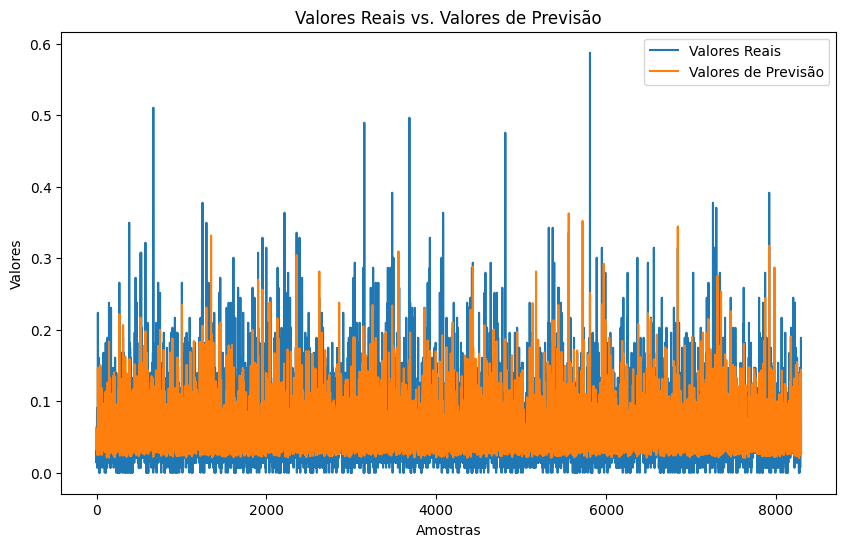

In [43]:

# Treinar o modelo com os melhores parâmetros encontrados
best_params = bayes_search.best_params_
model, val_losses = train_and_evaluate_lstm(input_size=input_size, **best_params, lr=0.001, weight_decay=1e-8, patience=5)

# Fazer predições
model.eval()
with torch.no_grad():
    y_pred = model(X_val.to(device)).cpu().numpy()

# Plotar os valores reais versus os valores de previsão
plt.figure(figsize=(10, 6))
plt.plot(y_val.numpy(), label='Valores Reais')
plt.plot(y_pred, label='Valores de Previsão')
plt.xlabel('Amostras')
plt.ylabel('Valores')
plt.title('Valores Reais vs. Valores de Previsão')
plt.legend()
plt.show()
